<a href="https://colab.research.google.com/github/neural-data-science-lab/DL-intro-2022/blob/main/MNIST-CNN-Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Where I took most of the inspiration and code from:

Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. </small>


Some hints:

Select GPU or TPU from Runtime

In [1]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 9.5 MB/s 


Setup of the compute environment

In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical
keras_backend.set_image_data_format('channels_last')
import visualkeras

Load the MNIST data

In [3]:
# number of classes (digits)
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


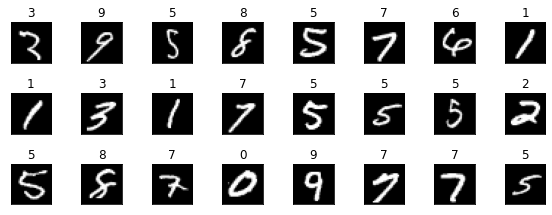

In [4]:
grid_x = 8
grid_y = 3
plt.figure(figsize=(1*grid_x, 2*grid_y))
for y in range(grid_y):
    for x in range(grid_x):
        index = x + (grid_x * y)
        plt_index = x + (grid_x * y)
        plt.subplot(2*grid_y, grid_x, 1+plt_index)
        img_index = index+500
        pred_data = np.reshape(x_train[img_index], (1, 28, 28, 1))
        plt.imshow(np.reshape(x_train[img_index],(28,28)),cmap='gray')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title(str(np.argmax(y_train[img_index])))
plt.tight_layout()
plt.show()

Set up a simple ConvNet for image classification

In [5]:
batch_size = 128
epochs = 20


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3),
                         activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ]
)

Visualize the model architecture using the visualkeras library.

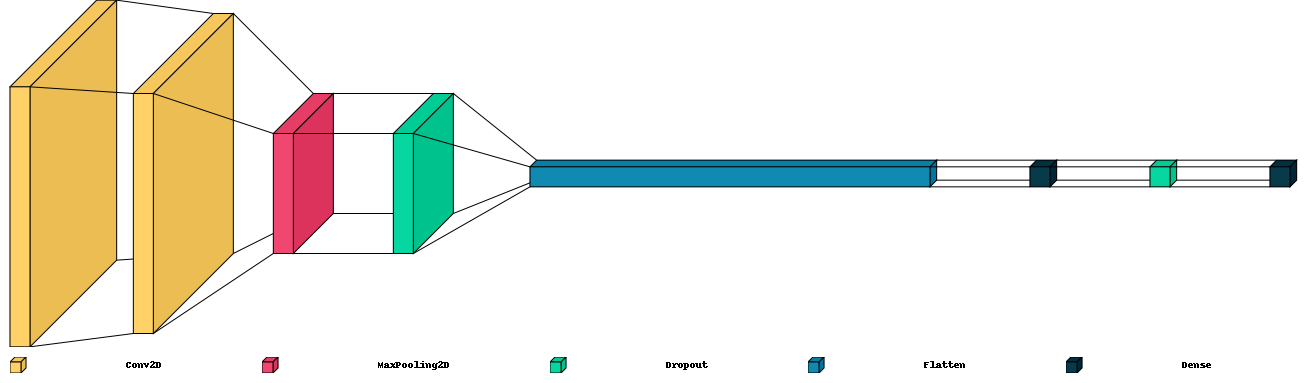

In [6]:
visualkeras.layered_view(model, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                      

compiling and training the model

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 16s 10ms/step - loss: 0.2464 - accuracy: 0.9256 - val_loss: 0.0508 - val_accuracy: 0.9834
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0879 - accuracy: 0.9735 - val_loss: 0.0453 - val_accuracy: 0.9851
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0648 - accuracy: 0.9808 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0536 - accuracy: 0.9835 - val_loss: 0.0305 - val_accuracy: 0.9892
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0454 - accuracy: 0.9857 - val_loss: 0.0277 - val_accuracy: 0.9905
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0394 - accuracy: 0.9869 - val_loss: 0.0287 - val_accuracy: 0.9904
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0329 - accuracy: 0.9897 - val_loss: 0.0280 - val_accuracy: 0.9905
Epoc

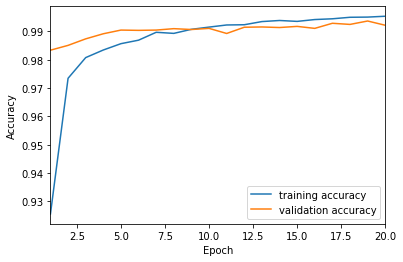

In [16]:
xs = list(range(1,1+len(history.history['accuracy'])))
plt.plot(xs, history.history['accuracy'], label='training accuracy')
plt.plot(xs, history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
plt.show()

Things to discuss:

*   How can you check from those curves if your model overfits?
*   If it overfits, what could you do?


Visualizing the predictions

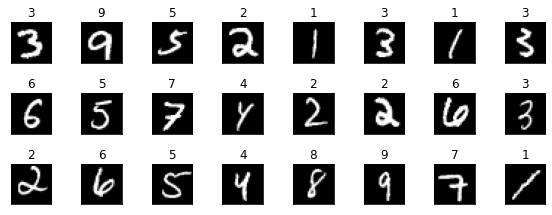

In [17]:
grid_x = 8
grid_y = 3
plt.figure(figsize=(1*grid_x, 2*grid_y))
for y in range(grid_y):
    for x in range(grid_x):
        index = x + (grid_x * y)
        plt_index = x + (grid_x * y)
        plt.subplot(2*grid_y, grid_x, 1+plt_index)
        img_index = index+500
        pred_data = np.reshape(x_test[img_index], (1, 28, 28, 1))
        pred = model.predict(pred_data, verbose=0)
        plt.imshow(np.reshape(x_test[img_index],(28,28)),cmap='gray')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title(str(np.argmax(pred)))
plt.tight_layout()
plt.show()

As a (not entirely fair) comparison, we can also try a logistic regression model. This is basically a one-layer neural network with a sigmoid activation function (well in this case the softmax as we are dealing with a multiclass or multinomial classification problem). However, in practice we would do some feature engineering and most likely not fit raw pixel values into a model. But just to see that you can often consider neural networks as an extension of existing models. 

In [26]:
batch_size = 128
epochs = 20


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        # try taking in/out the Dropout layer
        layers.Dropout(0.12),
        layers.Dense(num_classes, activation='softmax')
    ]
)

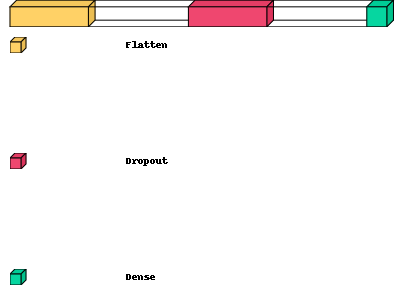

In [27]:
visualkeras.layered_view(model, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dropout_4 (Dropout)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7057 - accuracy: 0.8213 - val_loss: 0.3889 - val_accuracy: 0.8987
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3829 - accuracy: 0.8949 - val_loss: 0.3245 - val_accuracy: 0.9138
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3400 - accuracy: 0.9044 - val_loss: 0.2994 - val_accuracy: 0.9169
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3202 - accuracy: 0.9095 - val_loss: 0.2863 - val_accuracy: 0.9219
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.3103 - accuracy: 0.9124 - val_loss: 0.2821 - val_accuracy: 0.9211
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3017 - accuracy: 0.9157 - val_loss: 0.2759 - val_accuracy: 0.9231
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2976 - accuracy: 0.9166 - val_loss: 0.2702 - val_accuracy: 0.9253
Epoch 

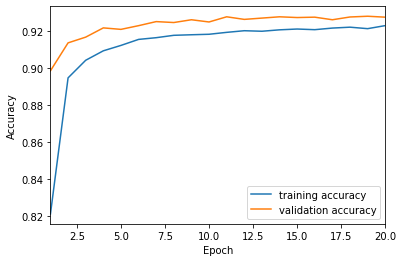

In [31]:
xs = list(range(1,1+len(history.history['accuracy'])))
plt.plot(xs, history.history['accuracy'], label='training accuracy')
plt.plot(xs, history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(1, len(xs))
plt.show()

In [ ]:
batch_size = 128
epochs = 20


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3),
                         activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ]
)

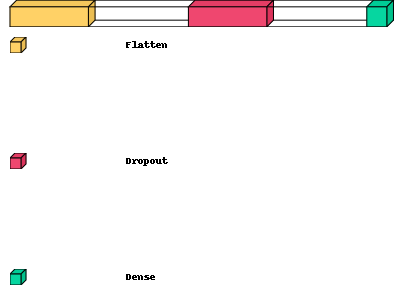

In [32]:
visualkeras.layered_view(model, legend=True, scale_xy=10, scale_z=0.1, draw_volume=True, spacing = 100)